In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# mis importaciones 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import yaml
import datetime


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Datos

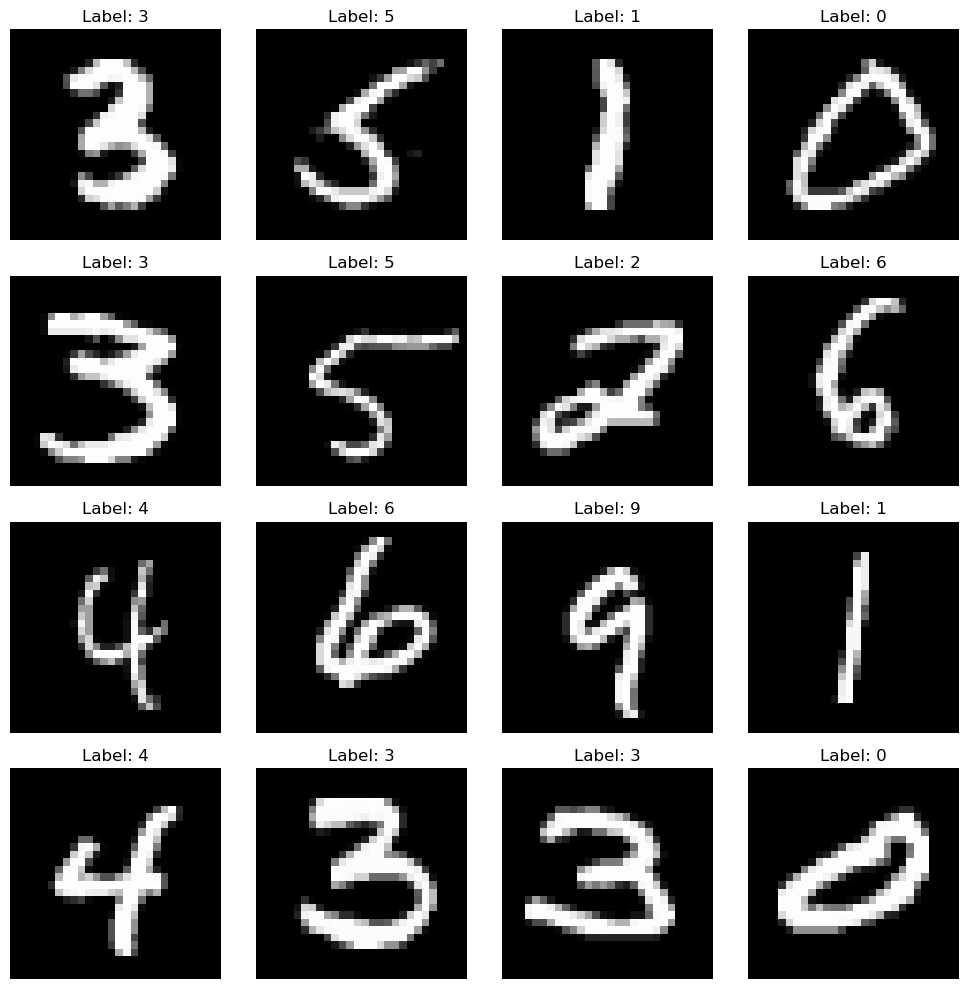

In [3]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

# Mis funciones opcionales

Sólo para guardar en un archivo `resultado.yaml` los parámetros de entrada que varían y el dataframe resultado con la pérdida final vs época. 
También se va a almacenar los gráficos en archivos png de la Pérdida vs Época.

**Graficar_Epocas_Perdicas** Grafico la Pérdida vs Época, y guardo la figura. 

**guardar_resultados_yaml** Guarda todos los parámetros, hiperparámetros, accuracy y el dataframe de Pérdida vs Época

**cargar_parametros** Cargará tanto los parámetros como los hiperparámetros donde se elige por código cual set de parámetros e hiperparámetros se usará. 

In [101]:
# Gráfico de la pérdida en el entrenamiento con barras
def Graficar_Epocas_Perdida(df, titulo):
    color_aleatorio = sns.color_palette("husl", 1)[0]
    plt.bar(df['Época'], df['Pérdida'], color=color_aleatorio, alpha=0.7)
    plt.xticks(ticks=range(1, df.shape[0]+1), labels=range(1, df.shape[0]+1))
    plt.grid(alpha=0.3)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title(titulo)

    # Guardar el gráfico
    if not os.path.exists('graficos'):
        os.makedirs('graficos')
        
    fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")    
    plt.savefig(f'graficos/{fecha}_grafico_{titulo}.png')
    plt.show()
    
#######################################    
# Guardar resultados en un archivo YAML    
def guardar_resultados_yaml(parametros, hiperparametros, df, accuracy, nombre_archivo):
    hr = datetime.datetime.now().strftime("%y-%m-%d_%f")  
    resultados = {
        'timestamp': hr,
        'resultado' : {
            'parametros': parametros,
            'hiperparametros': hiperparametros,
            'df': df.to_dict(orient='records'),
            'accuracy': accuracy
        }
    }
      
    if not os.path.exists('respuesta'):
        os.makedirs('respuesta')
    ruta_file = f'respuesta/{nombre_archivo}'
    
    # cargar los datos existentes en el archivo YAML
    try:
        with open(ruta_file, 'r') as file:
            old_respuesta = yaml.safe_load(file)
            if old_respuesta is None:
                old_respuesta = []
    except FileNotFoundError:
        old_respuesta = []

    old_respuesta.append(resultados)
    
    with open(ruta_file, 'w') as file:
        yaml.dump(old_respuesta, file, default_flow_style=False, allow_unicode=True)

#######################################
# Cargar parámetros desde un archivo YAML        
def cargar_parametros(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        parametros_cargados = yaml.safe_load(file)
    
    df_param = pd.DataFrame.from_dict(parametros_cargados)
    
    return df_param

##############################
# Setear los parametros 
def setear_parametros(col_param, parametro_file):
    df = cargar_parametros(parametro_file)
    # print(df, "\n")
    df_param = df[col_param]
    funcion_str = df_param.loc['activation_fn']
    tam_imagen = df_param.loc['tam_imagen']
    capas_ocultas = df_param.loc['capas_ocultas']
    tam_clase = df_param.loc['tam_clase']
    
    return tam_imagen, capas_ocultas, tam_clase, funcion_str

##############################
# Setear los hiperparametros 
def setear_hiperparametros(col_hiper, hiper_file):
    df = cargar_parametros(hiper_file)
    # print(df)
    df_hiper = df[col_hiper]
    batch_size = int(df_hiper.loc['batch_size'])
    learning_rate = float(df_hiper.loc['learning_rate'])
    epochs = int(df_hiper.loc['epochs'])
    optimizer_str = df_hiper.loc['optimizer_str']
    
    return batch_size, learning_rate, epochs, optimizer_str

##############################
# Leer resuladaos de un archivo YAML y ponerlos en un dataframe
def leer_resultados(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        resultados = yaml.safe_load(file)
    
    df_resultados = pd.DataFrame()
    for i in range(len(resultados)):
        df = pd.DataFrame(resultados[i]['resultado']['df'])
        df['timestamp'] = resultados[i]['timestamp']
        df['accuracy'] = resultados[i]['resultado']['accuracy']
        df['capas_ocultas'] = [resultados[i]['resultado']['parametros']['capas_ocultas']] * len(df)
        df['nro_capas'] = len(resultados[i]['resultado']['parametros']['capas_ocultas'])
        df['activation_fn'] = resultados[i]['resultado']['parametros']['activation_fn']
        df['batch_size'] = resultados[i]['resultado']['hiperparametros']['batch_size']
        df['learning_rate'] = resultados[i]['resultado']['hiperparametros']['learning_rate']
        df['epochs'] = resultados[i]['resultado']['hiperparametros']['epochs']
        df['optimizer_str'] = resultados[i]['resultado']['hiperparametros']['optimizer_str']
        
        
        df_resultados = pd.concat([df_resultados, df], ignore_index=True)
    
    return df_resultados


########################
import textwrap
pd.options.mode.copy_on_write = True 
# Graficar accuracy vs parámetros (con barras de diferentes colores)
def graficar_accuracy_parametros(df, nombre_col):
    plt.figure(figsize=(10, 6))
    etiquetas = [textwrap.fill(str(x), width=20) for x in df[nombre_col]]  # Dividir etiquetas largas
    bars = plt.bar(etiquetas, df['accuracy'], color=plt.cm.tab10.colors, edgecolor='black')

    # Personalizar la gráfica
    plt.title("Accuracy vs Set de Parámetros e Hiperparámetros", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xlabel("Set Parámetros e Hiperparámetros", fontsize=12)
    plt.xticks(rotation=45, fontsize=8)
    plt.grid(visible=True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Mostrar valores encima de cada barra
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                f'{bar.get_height():.2f}', ha='center', fontsize=8)

    plt.show()
    
#######################    
def escribir_label(x):
    return 'Res:' + str(x)[-6:]

#######################

# Reorganizar y regenerar el dataframe
def reorganizar_dataframe_comprimido(df):
    df_comprimido = df.loc[df.groupby('timestamp')['accuracy'].idxmax()] # Obtener el máximo accuracy por timestamp con idxmax indicando la fila
    df_comprimido = df_comprimido.reset_index(drop=True)
    # genero las columnas de parametros y hiperparametros para el dataframe comprimido
    df_comprimido['parametros'] = (
        "act_fn:" + df_comprimido['activation_fn'].astype(str) + " - " +
        "c:" + df_comprimido['nro_capas'].astype(str)
    )
    df_comprimido['hiperparametros'] = (
        "op_fn:" + df_comprimido['optimizer_str'].astype(str) + " - " +
        "batch:" + df_comprimido['batch_size'].astype(str) + " - " +
        "lr:" + df_comprimido['learning_rate'].astype(str) + " - " +
        "e:" + df_comprimido['epochs'].astype(str)
    )
    # como no me cupo en el gráfico, genero una etiqueta más corta
    df_comprimido['label'] = df_comprimido['timestamp'].apply(lambda x: escribir_label(x))
    df_final = df_comprimido[['label', 'accuracy', 'parametros', 'hiperparametros','timestamp']]
    

    return df_final    
    
    


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

# Arquitectura

In [13]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 784)
        self.fc2 = nn.Linear(784, 512)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc3 = nn.Linear(512, 256)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        self.fc4 = nn.Linear(256, 10)
        
        # Función de activación ReLU
        self.relu = nn.ReLU()
        # Dropout para evitar sobreajuste
        self.dropout = nn.Dropout(0.2)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.relu(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.relu(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.relu(self.fc3(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc4(x)             # Aplicamos la capa de salida
        return x

# Entrenamiento


In [14]:
# Hiperparámetros
batch_size = 64       # Tamaño de lote
learning_rate = 0.001 # Tasa de aprendizaje
epochs = 10           # Número de épocas de entrenamiento

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo

    # Mostramos la pérdida al final de cada época
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")



Época [1/10], Pérdida: 0.1608
Época [2/10], Pérdida: 0.0867
Época [3/10], Pérdida: 0.1629
Época [4/10], Pérdida: 0.1950
Época [5/10], Pérdida: 0.1426
Época [6/10], Pérdida: 0.0241
Época [7/10], Pérdida: 0.1601
Época [8/10], Pérdida: 0.0543
Época [9/10], Pérdida: 0.0173
Época [10/10], Pérdida: 0.2100


# Evaluación del modelo

In [16]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 97.15%


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

# Mi Clase dínamica de MLP_D

In [5]:

class MLP_D(nn.Module):
    def __init__(self, tam_imagen, capas_ocultas, tam_clase, activation_fn=nn.ReLU, dropout_prob=0.2):
        super(MLP_D, self).__init__()
        
        # se crean las capas desde las listas capas_ocultas y tam_clase, y se guardan en self.capas (nn.ModuleList)
        self.capas = nn.ModuleList()
        # primera capa
        self.capas.append(nn.Linear(tam_imagen, capas_ocultas[0]))
        # capas ocultas
        for i in range(1, len(capas_ocultas)):
            self.capas.append(nn.Linear(capas_ocultas[i-1], capas_ocultas[i]))
        # ultima capa
        self.capas.append(nn.Linear(capas_ocultas[-1], tam_clase))
        
        # Instanciar la función de activación pasada por parámetro
        self.activation_fn = activation_fn() 
        # se guarda la probabilidad de dropout        
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Aplanar la imagen a 1D
        x = x.view(x.size(0), -1)  
        
        # Pasar por las capas ocultas con activación y dropout
        for capa in self.capas[:-1]:  # Todas menos la última capa
            x = self.activation_fn(capa(x))  # Usar la función de activación
            x = self.dropout(x)
        
        # Pasar por la última capa (sin activación ni dropout)
        x = self.capas[-1](x)           
        return x

## Entreno la parte dinámica de la Clase MLP_D

Tuve que fijar la semilla aleatoria en todas las librerías relevantes. Esto incluye PyTorch, NumPy, y Python. Porque al graficar me salían valores diferentes con los mismos valores. 

Dejé en un archivo `parametros.yaml` los parámetros a cambiar. Luego los muestro en un dataframe. Como guarde el nombre de la función de activación de la misma manera como se llama en la clase de nn.XXX y luego puedo hacer el `getattr(nn, funcion_str)`

Lo mismo por el archivo `hiperparametros.yamml`.

Se crea la función `setear_parametros(col_param, parametro_file)` y `setear_hiperparametros(col_hiper, hiper_file` donde se tiene como entrada el nombre del conjunto de parámetros (o hiperparámetros) que se ha elegido, más el archivo donde están estos datos. Como salida retorna estos parámetros (o hiperparámetros) en tupls de N elementos. 

setear_parametros(col_param, parametro_file) -> activacion_fn, tam_imagen, capas_ocultas, tam_clase, funcion_str

setear_hiperparametros(col_hiper, hiper_file) -> batch_size, learning_rate, epochs, optimizer_fn, optimizer_str

Diferentes funciones de optimización pueden ser:  Adam, SGD, RMSprop, Adagrad, Adadelta, AdamW, ASGD

Diferentes funciones de activación pueden ser: Tanh, Softplus, Sigmoid, GELU, Softmax

In [104]:
# Fijar la semilla para reproducibilidad
seed = 42  
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# lo dejo en una función para poder reutilizarlo dentro de un bucle con mis parámetros e hiperparámetros
def procesar_MNIST(col_param, col_hiper):
    # Setear los valores de los parámetros e hiperparámetros para este modelo tienen como parámetro la función de activación y la función de optimización
    tam_imagen, capas_ocultas, tam_clase, funcion_str = setear_parametros(col_param, 'parametros.yaml')
    activation_fn = getattr(nn, funcion_str)

    batch_size, learning_rate, epochs, optimizer_str = setear_hiperparametros(col_hiper, 'hiperparametros.yaml')
    optimizer_fn = getattr(optim, optimizer_str)

    # estos son los parametros que se van a usar, los guardo en dictionarios para guardarlos en el archivo YAML
    parametros = {
        'tam_imagen': tam_imagen,
        'capas_ocultas': capas_ocultas,
        'tam_clase': tam_clase,
        'activation_fn': funcion_str,
        }
    hiperparametros = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'optimizer_str': optimizer_str
        }

    # Preprocesamiento y carga de datos de MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),                 # Convertimos imágenes a tensores
        transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
    ])
    train_dataset = datasets.MNIST(
        root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
    test_dataset = datasets.MNIST(
        root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

    # Definimos el modelo, la función de pérdida y el optimizador
    modelo = MLP_D(tam_imagen, capas_ocultas, tam_clase, activation_fn)  # Creamos una instancia del modelo MLP_D
    criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
    # Optimizador Adam, SGD, RMSprop, Adagrad, Adadelta, AdamW, ASGD
    optimizer = optimizer_fn(modelo.parameters(), lr=learning_rate)


    epocas = {}
    # Bucle de entrenamiento
    for epoch in range(epochs):
        modelo.train()  # Ponemos el modelo en modo entrenamiento
        for images, labels in train_loader:  # Iteramos sobre lotes de datos
            optimizer.zero_grad()            # Reiniciamos los gradientes
            outputs = modelo(images)          # Hacemos una predicción con el modelo
            loss = criterion(outputs, labels)  # Calculamos la pérdida
            loss.backward()                  # Propagamos los gradientes
            optimizer.step()                 # Actualizamos los pesos del modelo

        # Mostramos la pérdida al final de cada época
        # print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")
        epocas[epoch+1] = round(loss.item(), 4)

    # lo pongo en un data frame
    df = pd.DataFrame(epocas.items(), columns=['Época', 'Pérdida'])
    Graficar_Epocas_Perdida(df, "Pérdidas vs Épocas")   
    modelo.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
    correct = 0
    total = 0
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
        for images, labels in test_loader:  # Iteramos sobre los datos de prueba
            outputs = modelo(images)         # Hacemos predicciones
            _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
            total += labels.size(0)         # Total de muestras evaluadas
            correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

    # Calculamos y mostramos la precisión del modelo
    accuracy = 100 * correct / total
    print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")
    # Guardar resultados en un archivo YAML junto con sus parámetros e hiperparámetros
    guardar_resultados_yaml(parametros, hiperparametros, df, accuracy, 'resultados.yaml')
    


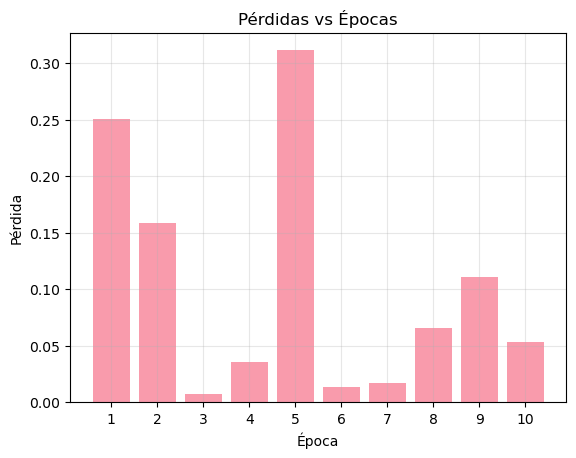

Accuracy en el conjunto de prueba: 97.63%


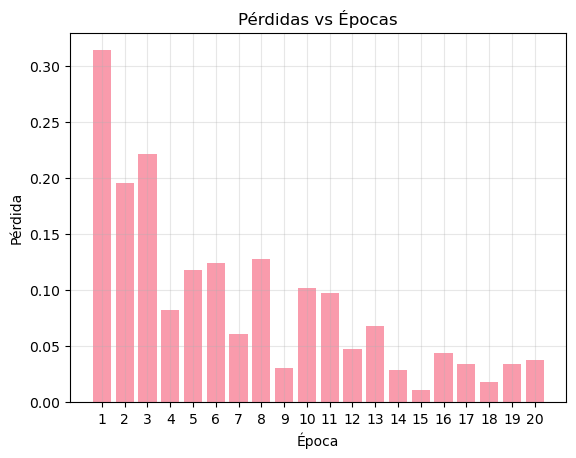

Accuracy en el conjunto de prueba: 98.32%


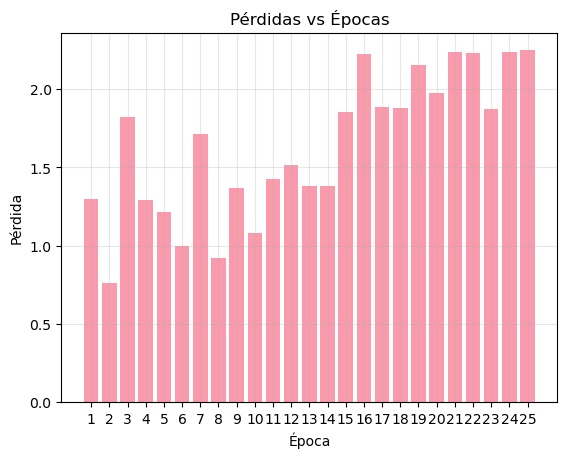

Accuracy en el conjunto de prueba: 16.57%


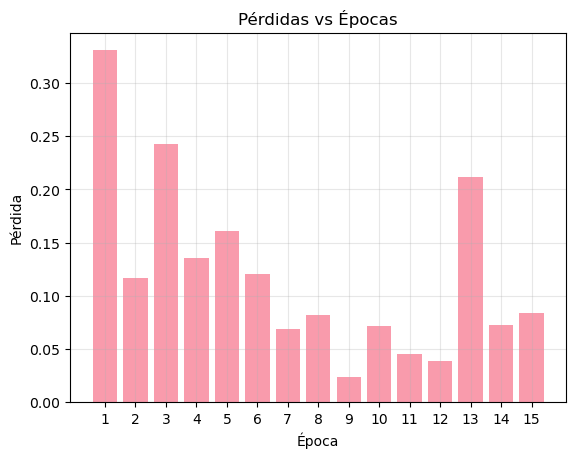

Accuracy en el conjunto de prueba: 97.90%


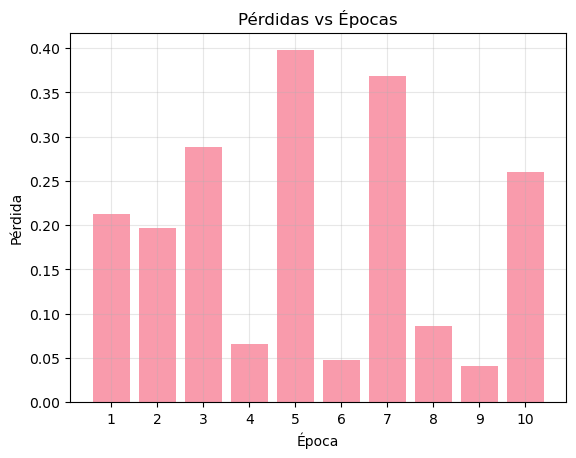

Accuracy en el conjunto de prueba: 95.73%


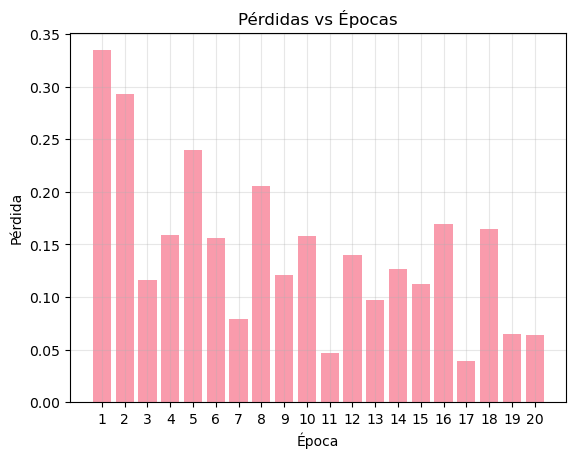

Accuracy en el conjunto de prueba: 97.82%


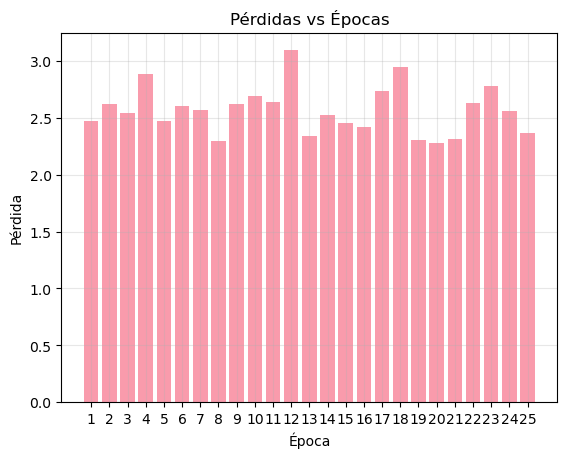

Accuracy en el conjunto de prueba: 10.32%


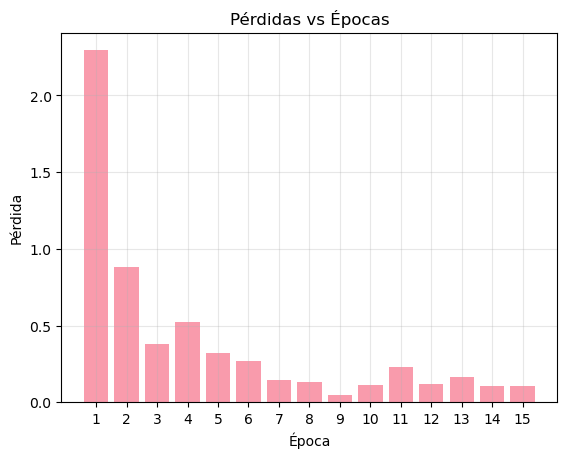

Accuracy en el conjunto de prueba: 95.72%


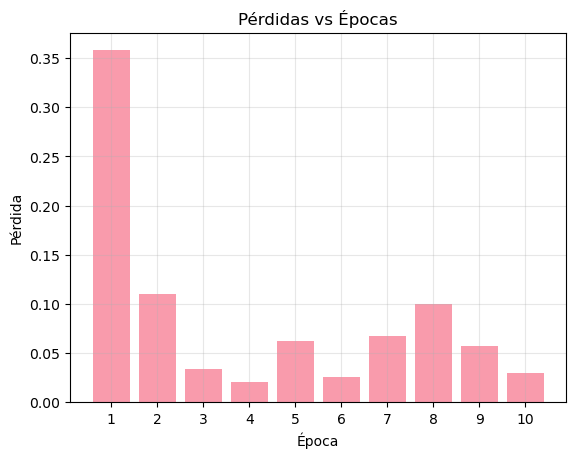

Accuracy en el conjunto de prueba: 97.16%


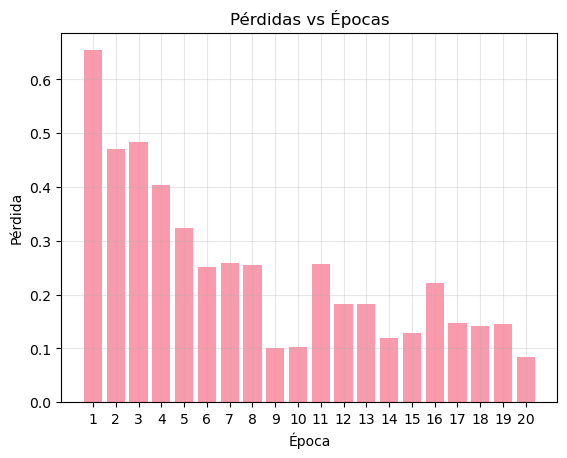

Accuracy en el conjunto de prueba: 96.74%


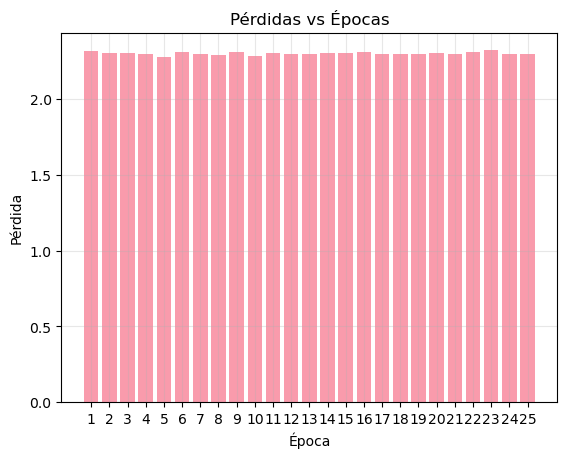

Accuracy en el conjunto de prueba: 10.32%


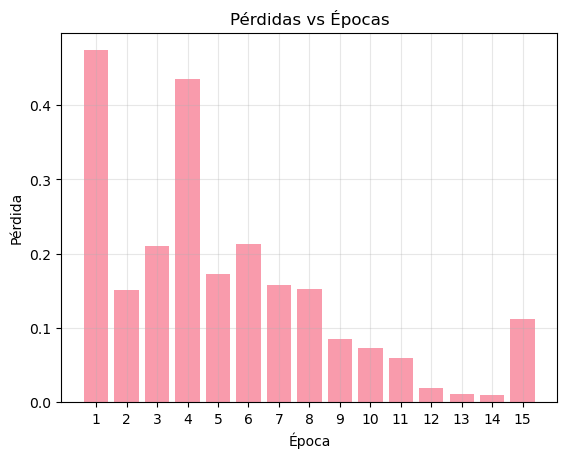

Accuracy en el conjunto de prueba: 95.52%


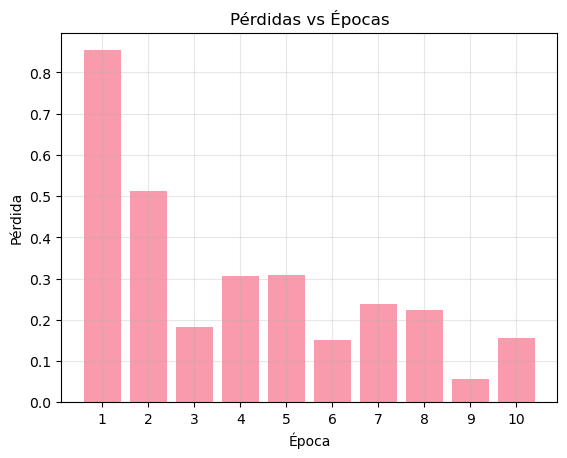

Accuracy en el conjunto de prueba: 97.03%


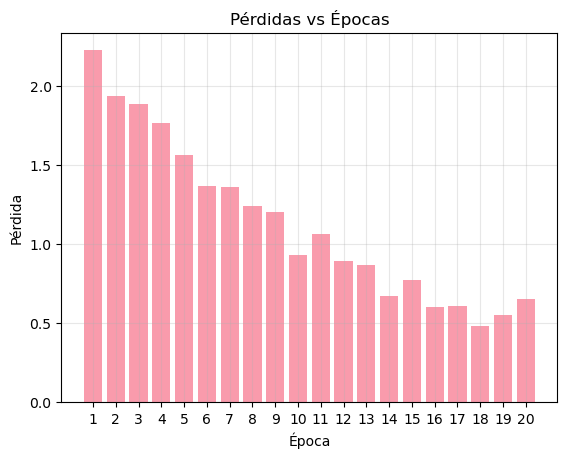

Accuracy en el conjunto de prueba: 83.54%


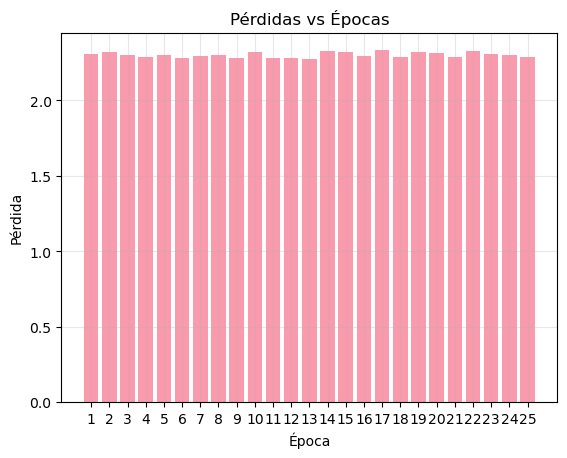

Accuracy en el conjunto de prueba: 11.35%


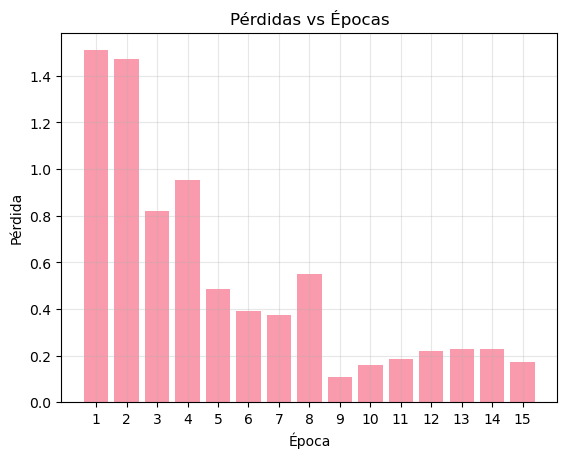

Accuracy en el conjunto de prueba: 96.11%


In [105]:
for i in range(4):
    col_param = f'parametros_{i+1}'
    for j in range(4):
        col_hiper = f'hiperparametros_{j+1}'
        procesar_MNIST(col_param, col_hiper)

In [106]:
# rescatar resultados de un archivo YAML y ponerlos en un dataframe
df_resultados = leer_resultados('respuesta/resultados.yaml')

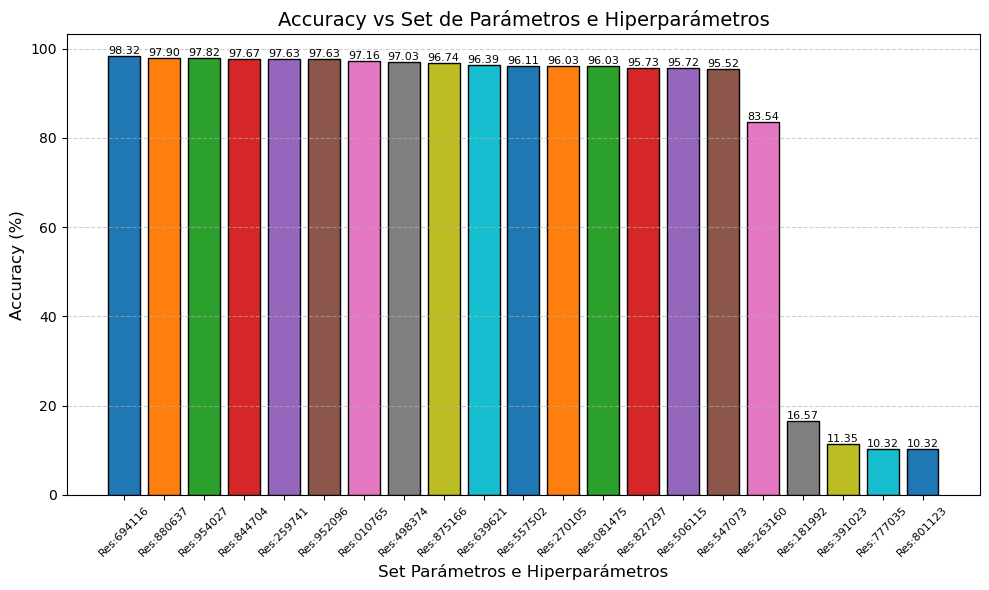

El mejor modelo es el set de Res:694116 con los parámetros  act_fn:ReLU - c:3 
con un accuracy de 98.32% 
con los hiperparámetros op_fn:RMSprop - batch:128 - lr:0.0001 - e:20


,label,accuracy,parametros,hiperparametros,timestamp
14,Res:694116,98.32,act_fn:ReLU - c:3,op_fn:RMSprop - batch:128 - lr:0.0001 - e:20,24-12-18_694116
19,Res:880637,97.90,act_fn:ReLU - c:3,op_fn:RMSprop - batch:256 - lr:0.001 - e:15,24-12-18_880637
20,Res:954027,97.82,act_fn:Tanh - c:4,op_fn:RMSprop - batch:128 - lr:0.0001 - e:20,24-12-18_954027
3,Res:844704,97.67,act_fn:Softplus - c:4,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-15_844704
7,Res:259741,97.63,act_fn:ReLU - c:3,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-18_259741
4,Res:952096,97.63,act_fn:ReLU - c:3,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-15_952096
5,Res:010765,97.16,act_fn:Softplus - c:4,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-18_010765
10,Res:498374,97.03,act_fn:Sigmoid - c:5,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-18_498374
18,Res:875166,96.74,act_fn:Softplus - c:4,op_fn:RMSprop - batch:128 - lr:0.0001 - e:20,24-12-18_875166
2,Res:639621,96.39,act_fn:Sigmoid - c:5,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-15_639621


In [114]:
#reorganizar y regenerar el dataframe, de forma de tener un solo registro por timestamp en el maximo accuracy
df_final = reorganizar_dataframe_comprimido(df_resultados)
df_final = df_final.sort_values(by='accuracy', ascending=False)
graficar_accuracy_parametros(df_final, 'label')
max_index_accuracy = df_final['accuracy'].idxmax()
respuesta_final = f'El mejor modelo es el set de {df_final.loc[max_index_accuracy, "label"]} con los parámetros  {df_final.loc[max_index_accuracy, "parametros"]} \n' +f'con un accuracy de {df_final.loc[max_index_accuracy, "accuracy"]:.2f}% \n' +f'con los hiperparámetros {df_final.loc[max_index_accuracy, "hiperparametros"]}'
print(respuesta_final)
exportar = df_final.to_csv('respuesta/df_final.csv', sep=";", index=False)
df_final

